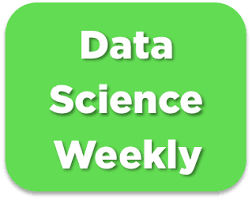

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [21]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix,classification_report
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [4]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [5]:
data_sample.info()

display(data_sample.describe())

display(data_sample.country.value_counts())
display(data_sample.source.value_counts())
data_sample.converted.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 268742 to 195583
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              10000 non-null  object
 1   age                  10000 non-null  int64 
 2   new_user             10000 non-null  int64 
 3   source               10000 non-null  object
 4   total_pages_visited  10000 non-null  int64 
 5   converted            10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 546.9+ KB


,age,new_user,total_pages_visited,converted
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,30.522400,0.684000,4.855500,0.033300
std,8.271502,0.464936,3.350514,0.179428
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,6.000000,0.000000
max,69.000000,1.000000,29.000000,1.000000


country
US         5656
China      2402
UK         1541
Germany     401
Name: count, dtype: int64

source
Seo       4891
Ads       2803
Direct    2306
Name: count, dtype: int64

converted
0    9667
1     333
Name: count, dtype: int64

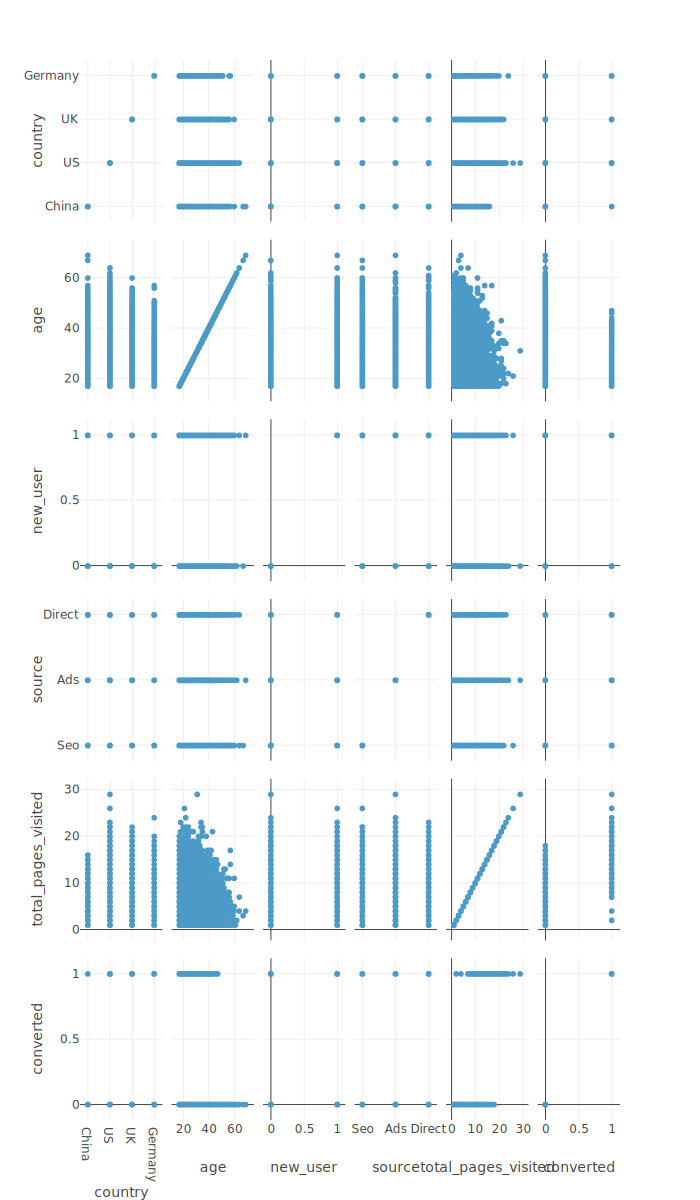

In [6]:
fig=px.scatter_matrix(data_sample,width=700,height=1200)
fig.show()

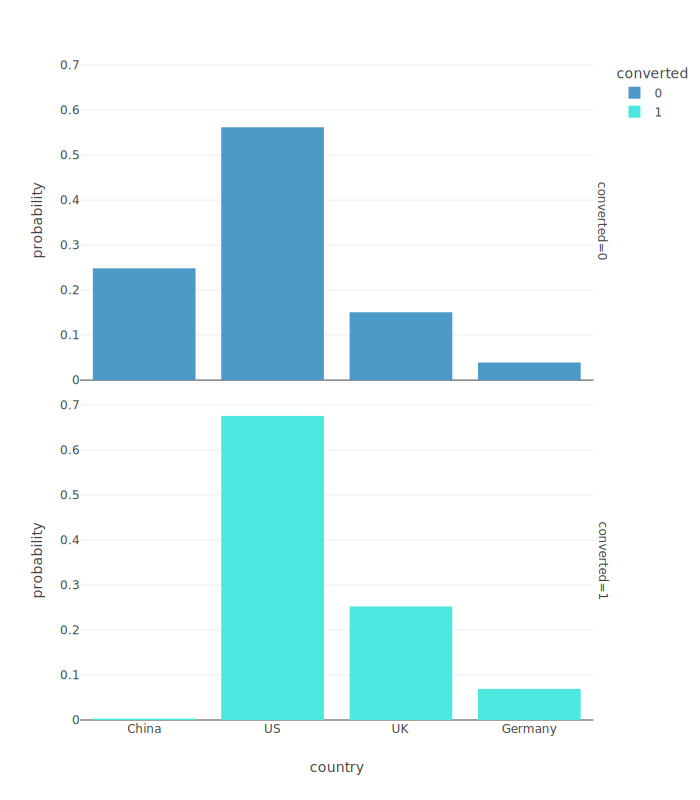

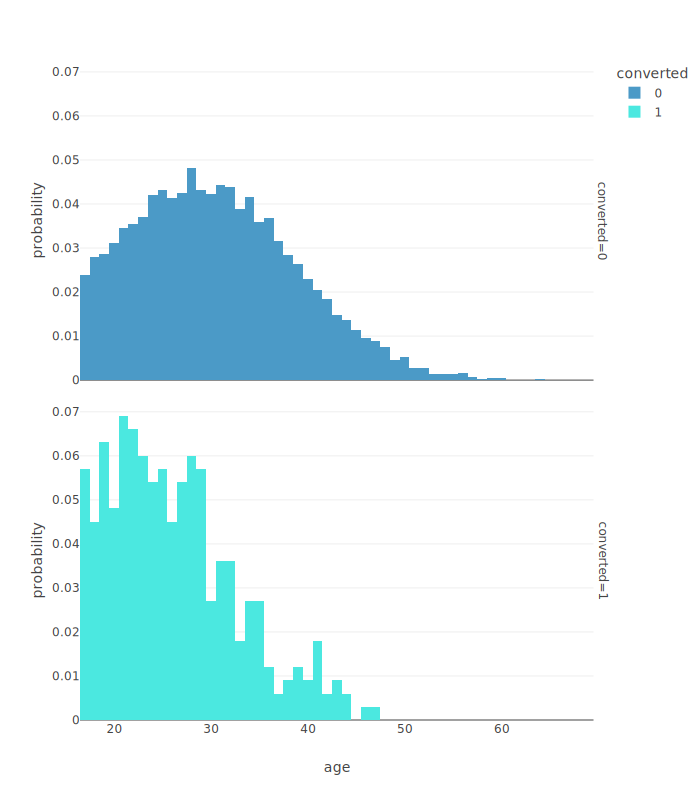

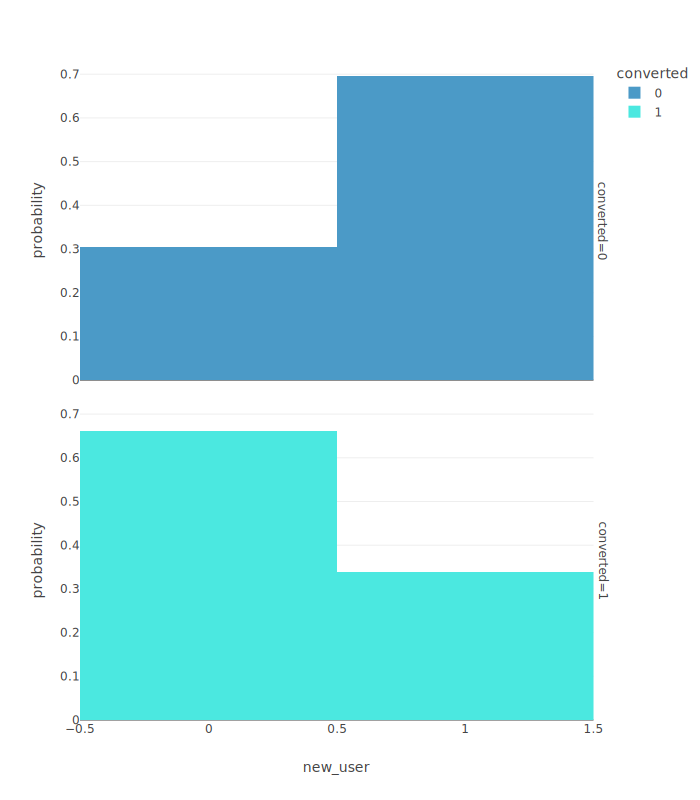

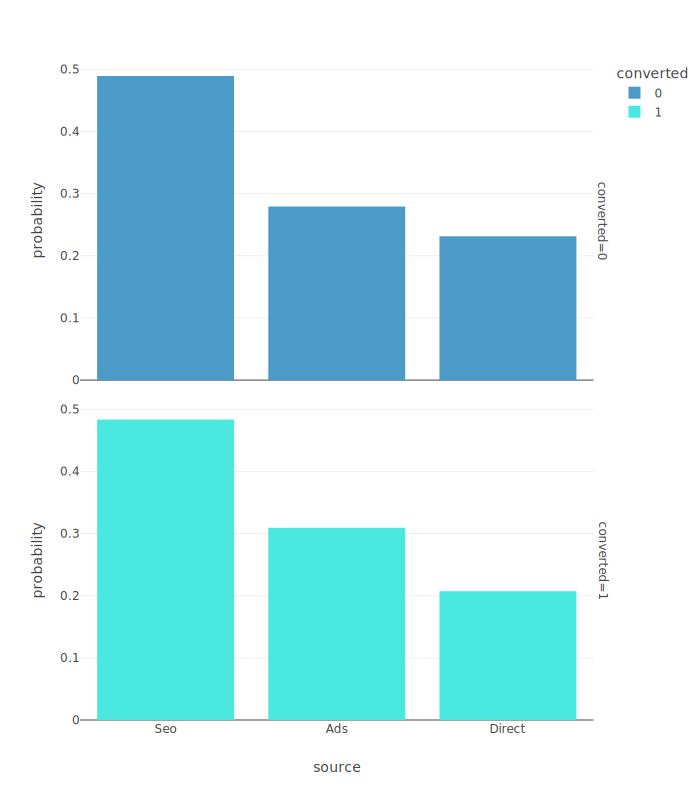

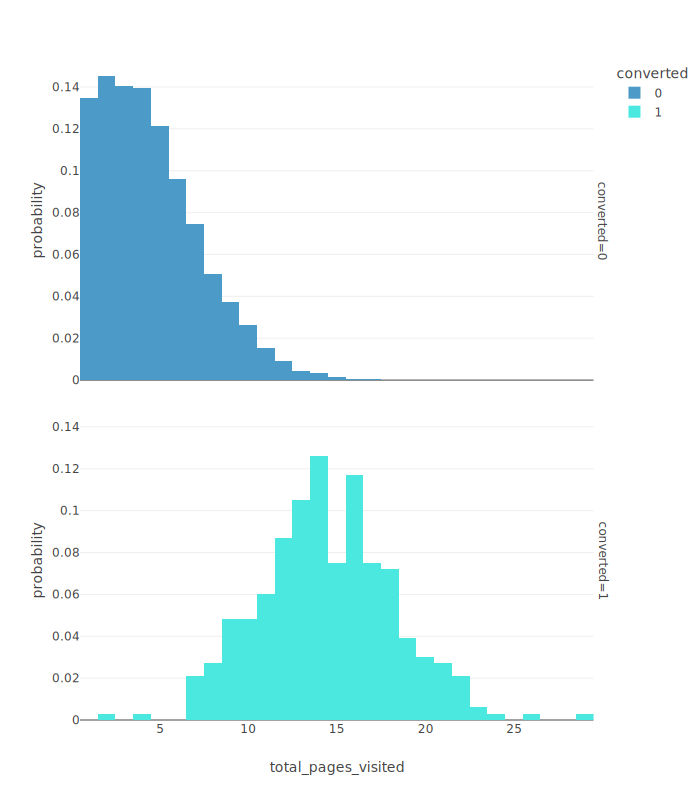

In [7]:
num_features = data_sample.drop('converted',axis=1)
for f in num_features:
    fig = px.histogram(
        data_sample, f, color="converted", facet_row="converted", histnorm="probability",width=700,height=800
    )
    fig.show()

# Make your model

## Training pipeline

In [8]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [9]:
print("Separating labels from features...")
target_variable = "converted"

X = data.drop(target_variable, axis = 1)
Y = data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3


In [10]:
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0, stratify=Y
)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [11]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

numeric_indices=['new_user','total_pages_visited','age']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_indices=['source','country']
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

Encoding categorical features and standardizing numerical features...


In [12]:
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5])
print()


print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) 
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
137434   China   19         1     Seo                    1
112323      US   33         1  Direct                    5
143261      US   51         1     Ads                    2
162328   China   17         0     Seo                    1
158039   China   28         1     Seo                    5
...Done.
[[ 0.67651656 -1.15935344 -1.3990984   0.          1.          0.
   0.          0.        ]
 [ 0.67651656  0.03743241  0.29299544  1.          0.          0.
   0.          1.        ]
 [ 0.67651656 -0.86015697  2.46854467  0.          0.          0.
   0.          1.        ]
 [-1.47816042 -1.15935344 -1.64082609  0.          1.          0.
   0.          0.        ]
 [ 0.67651656  0.03743241 -0.31132378  0.          1.          0.
   0.          0.        ]]

Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
138303      UK   34         

In [24]:
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 4, 8],
    "n_estimators": [20, 30],
}
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=3
)  # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
Best validation accuracy :  0.9861550354908989


In [25]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()


Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [26]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7676582761250953
f1-score on test set :  0.7440729483282674


## Performance assessment

In [27]:
Y_test_pred = gridsearch.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.84      0.67      0.74      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.83      0.87     56916
weighted avg       0.98      0.99      0.98     56916



In [28]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

RandomForestClassifier()

In [29]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country',	'age',	'new_user',	'source',	'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to arrays before using scikit-learn
print("Convert pandas DataFrames to arrays...")
#X_without_labels = X_without_labels.values
print("...Done")

#print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to arrays...
...Done


In [30]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-1.47816042  3.3285935  -0.31132378  0.          1.          0.
   1.          0.        ]
 [ 0.67651656  0.03743241 -1.03650686  1.          0.          0.
   1.          0.        ]
 [ 0.67651656 -1.15935344  0.1721316   0.          1.          0.
   0.          0.        ]
 [ 0.67651656  0.33662888  0.1721316   0.          0.          0.
   0.          1.        ]
 [-1.47816042 -0.56096051 -0.67391532  0.          1.          0.
   0.          0.        ]]


In [32]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': gridsearch.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_fredtest2.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**